In [1]:
import magnonRPA as rpa
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import colors as mclr

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

## Tests using box spectral functions which are analytically solvable

In [102]:
T = 0.11*rpa.t
U = 7.5*rpa.t
J = 4.*rpa.t**2/U

W = 8.*rpa.t
mu = -.36*W  

### Testing with box model 
kxs = np.linspace(0.,2.*np.pi,40)
kys = np.linspace(0.,2.*np.pi,40)
ws = np.linspace(-10.*rpa.t,10.*rpa.t,1000)
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)

Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)

test_A = rpa.gen_box_A(kxs,kys,ws,W)

delta = rpa.calc_density(kxs,kys,ws,test_A,mu,T)
print("Hole doping: {d:0.1%}".format(d=delta))

### Calculate RPA spectra from hole spectra 
ImPi0,ImPi1 = rpa.calc_ImPi(kxs,kys,ws,test_A,mu,T)
Pi0 = rpa.Kramers_Kronig(ws,ImPi0)
Pi1 = rpa.Kramers_Kronig(ws,ImPi1)

### Magnon propagators 
magnon_kernel = rpa.RPA_kernel(kxs,kys,ws,Pi0,Pi1,J)
magnon_propagator = np.zeros_like(magnon_kernel)
response_functions = np.zeros((4,Nkx,Nky,Nw),dtype=complex) ### This will be the four different Pauli tensor contractions in tau_[0,1,2,3] channel

for i in range(len(kxs)):
    for j in range(len(kys)):
        for k in range(len(ws)):
            magnon_propagator[:,:,i,j,k] = np.linalg.inv(magnon_kernel[:,:,i,j,k])

for i in range(4):
    response_functions[i,:,:,:] = np.tensordot(rpa.tau_projected[i],magnon_propagator,axes=2) 

Hole doping: 14.1%


## Plotting and diagnostics

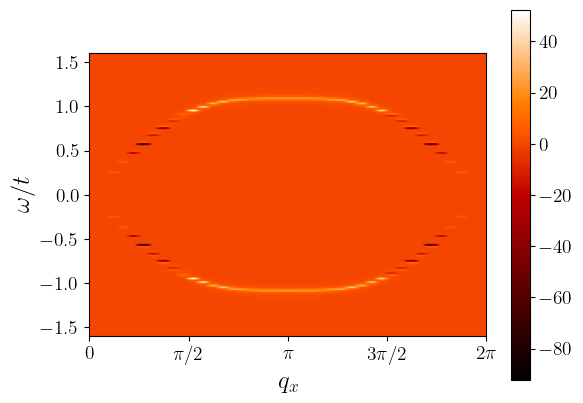

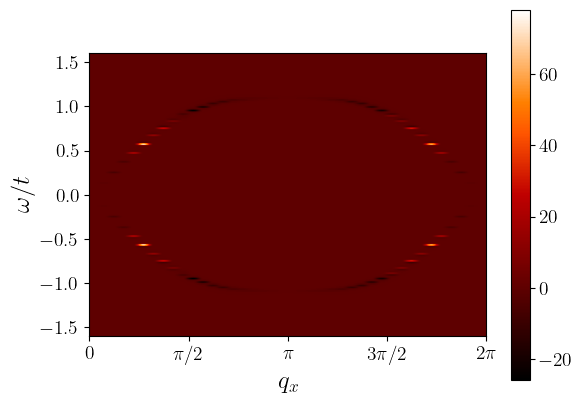

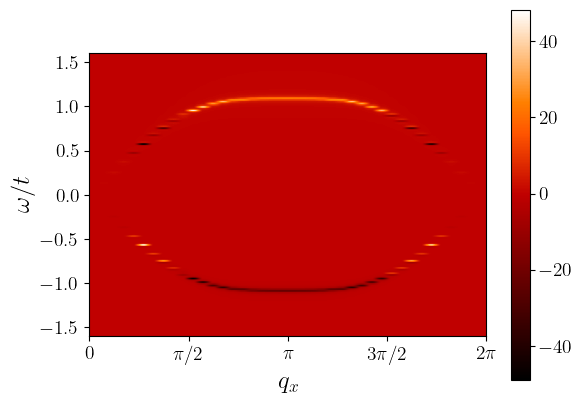

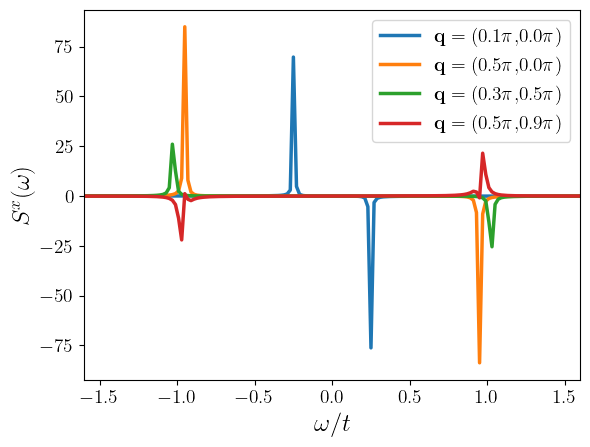

In [106]:
### Frequency cuts of magnon propagator spectral function trace 
indices = [ [2,0],[10,0],[5,10],[10,18]]
clrs = ['red','green','blue','purple']
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]


### Frequency dependence of Pi for kx cut 
if False:
    plt.imshow(np.transpose(ImPi0[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
    plt.xlabel(r'$q_x$')
    plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.ylabel(r'$\omega/t$')
    plt.colorbar()
    plt.show()

### Frequency cuts of polarizations of magnons
if False:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.real(Pi0[i[0],i[1],:])/rpa.t,label=label_strings[j])
    
    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Re$\Pi_0(\omega,\mathbf{q})/t$')
    plt.legend()
    plt.show()

if False:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.imag(Pi0[i[0],i[1],:])/rpa.t,label=label_strings[j],color=clrs[j])

    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Im$\Pi_0(\omega,\mathbf{q})/t$')
    plt.legend()
    plt.show()

spectral_indices=[0,1,3]
if True:
    for i in spectral_indices:
        plt.imshow(np.transpose(-1./np.pi*np.imag(response_functions[i,:,0,:]*wvs[:,0,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=1.4,cmap='gist_heat')#,norm=mclr.LogNorm())
        plt.ylabel(r'$\omega/t$')
        plt.ylim(-3.*J,3.*J)
        plt.xlabel(r'$q_x$')
        plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
        plt.colorbar()
        plt.show()

if True:
    for j in range(len(indices)):
        idx = indices[j]
        plt.plot(ws,-np.imag(response_functions[1,idx[0],idx[1],:]),label=label_strings[j])
    plt.ylabel(r'$S^x(\omega)$')
    plt.xlim(-3.*J,3.*J)
    #plt.yscale('log')
    plt.xlabel(r'$\omega/t$')
    plt.legend()
    plt.show()


## Set parameters, load hole spectral functions, and compute doping 

In [35]:
T = 0.11*rpa.t
U = 7.5*rpa.t
J = 4.*rpa.t**2/U
mu = -2.4*rpa.t ### Chemical potential 

figDirectory = "../figures/"
dataDirectory = "../data/"

saveFigs = False

holesDirectory = dataDirectory+"hole_spectra/03252025/"
holesFile = "Hole_Spectral_functionJz0.0_alfa0.999_Nx20_Ny20"#"Hole_Spectral_functionJz0.05_alfa0.999_Nx20_Ny20"

kxs,kys,ws,A = rpa.load_hole_spectrum(holesDirectory+holesFile)
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)
Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)
delta = rpa.calc_density(kxs,kys,ws,A,mu,T)
print("Hole doping: {d:0.1%}".format(d=delta))

Hole doping: 11.8%


## Computing using hole spectral functions from Ivan's SCBA

In [36]:
### Calculate RPA spectra from hole spectra 
ImPi = rpa.calc_ImPi(kxs,kys,ws,A,mu,T)
Pi = rpa.Kramers_Kronig(ws,ImPi)

In [37]:
### Magnon propagators 
magnon_kernel = rpa.RPA_kernel(kxs,kys,ws,Pi,J)
magnon_propagator = np.zeros_like(magnon_kernel)
spectra = np.zeros((2,Nkx,Nky,Nw),dtype=complex)

for i in range(len(kxs)):
    for j in range(len(kys)):
        for k in range(len(ws)):
            magnon_propagator[:,:,i,j,k] = np.linalg.inv(magnon_kernel[:,:,i,j,k])
            spectra[:,i,j,k] = np.linalg.eig(magnon_propagator[:,:,i,j,k])[0]


## Plotting and various diagonostics

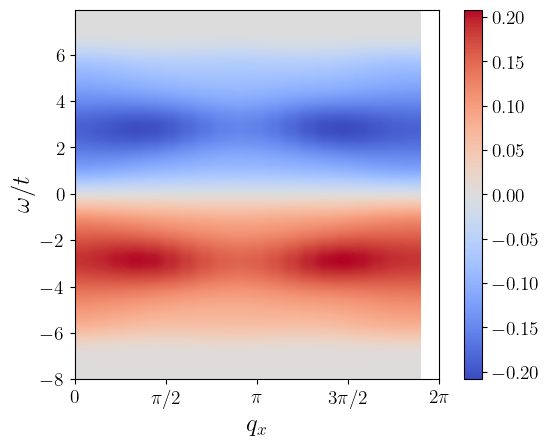

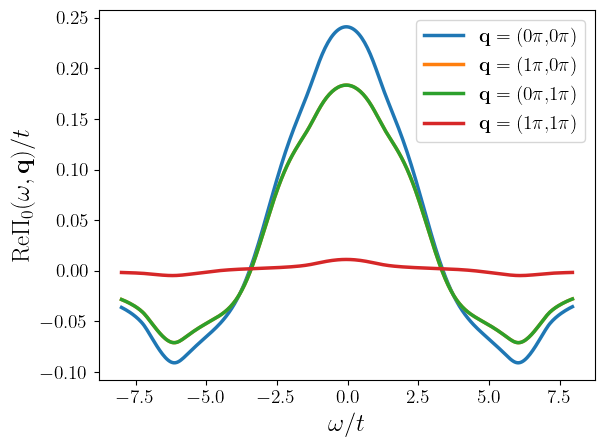

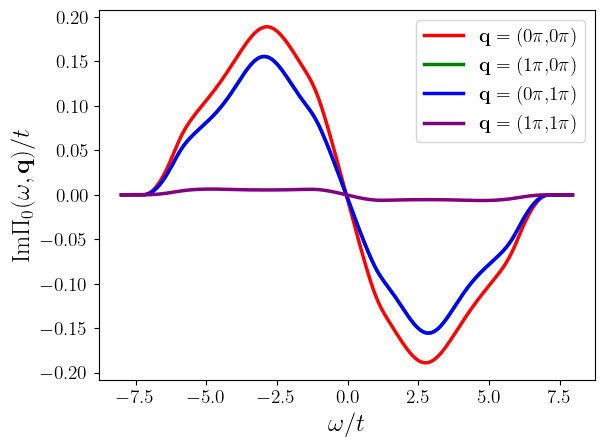

In [38]:
### Frequency cuts of magnon propagator spectral function trace 
indices = [ [0,0],[10,0],[0,10],[10,10]]
clrs = ['red','green','blue','purple']
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.0f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.0f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]


### Frequency dependence of Pi for kx cut 
plt.imshow(np.transpose(ImPi[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$\omega/t$')
plt.colorbar()
if saveFigs: plt.savefig(figDirectory+"/ImPi0_w_qx.pdf",bbox_inches='tight')
plt.show()

### Frequency cuts of polarizations of magnons
if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.real(Pi[i[0],i[1],:])/rpa.t,label=label_strings[j])
    
    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Re$\Pi_0(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/RePi0.pdf",bbox_inches='tight')
    plt.show()

if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.imag(Pi[i[0],i[1],:])/rpa.t,label=label_strings[j],color=clrs[j])

    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Im$\Pi_0(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/ImPi0.pdf",bbox_inches='tight')
    plt.show()


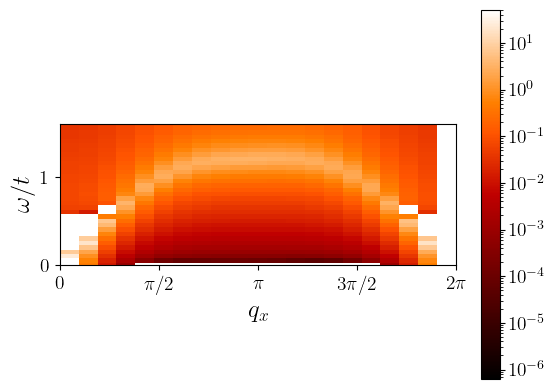

In [39]:
plt.imshow(np.transpose(-1./np.pi*np.imag(np.trace(magnon_propagator[:,0,:]))),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=1.4,cmap='gist_heat',norm=mclr.LogNorm())
plt.ylabel(r'$\omega/t$')
plt.ylim(0.*J,3.*J)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
#if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()

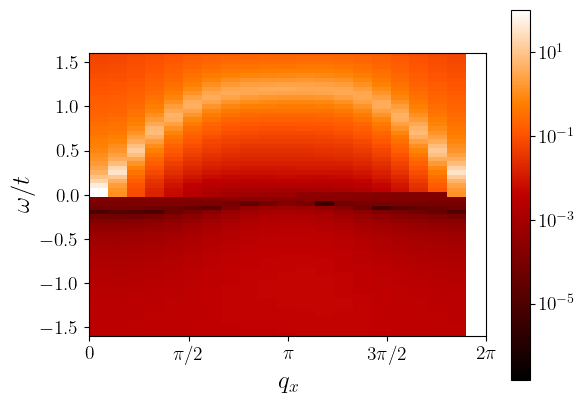

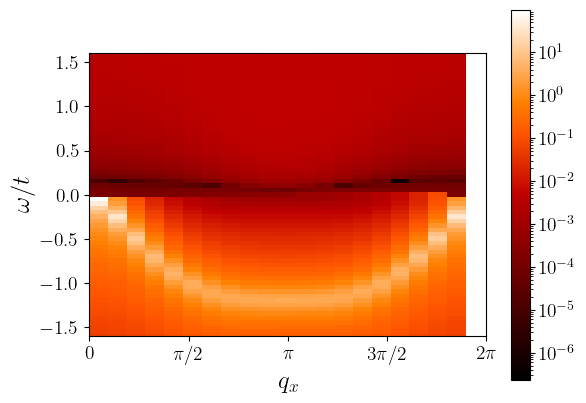

In [40]:
for i in range(2):
    plt.imshow(1./np.pi*np.transpose(np.abs(np.imag(spectra[i,:,0,:])) ),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=1.4,cmap='gist_heat',norm=mclr.LogNorm())
    plt.ylabel(r'$\omega/t$')
    plt.ylim(-3.*J,3.*J)
    plt.xlabel(r'$q_x$')
    plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.colorbar()
    #if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
    plt.show()